In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd


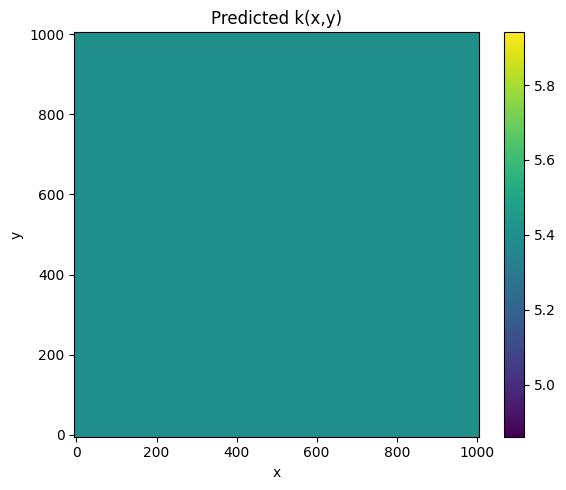

In [17]:

# Configuración de dispositivo
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

# Función k verdadera en 2D (solo depende de y)
def k_true_np(XY_np):
    y = XY_np[:, 1:2]
    epsilon = 125   # Steepness of the sigmoid
    y0 = 500        # Midpoint of the sigmoid
    k_true = 1.5 + 1.0 / (1 + np.exp(-(y - y0) / epsilon))
    return k_true

# 1) Generación de datos de entrenamiento
N_train = 10000
x_train = np.random.uniform(0,1000, (N_train, 1))
y_train = np.random.uniform(0, 1000, (N_train, 1))
XY_train = np.hstack([x_train, y_train])
k_train_np = k_true_np(XY_train)

XY_train_t = torch.tensor(XY_train, dtype=torch.float32, device=device)
k_train_t  = torch.tensor(k_train_np, dtype=torch.float32, device=device)

# 2) Definición de la red PINN_k_2D
class PINN_k_2D(nn.Module):
    def __init__(self, input_size=2, hidden_layers=12, hidden_units=128, act=nn.Tanh()):
        super().__init__()
        self.in_layer = nn.Linear(input_size, hidden_units)
        self.hidden   = nn.ModuleList([
            nn.Linear(hidden_units, hidden_units) 
            for _ in range(hidden_layers)
        ])
        self.act      = act
        self.out      = nn.Linear(hidden_units, 1)

    def forward(self, x):
        h = self.act(self.in_layer(x))
        for layer in self.hidden:
            h = self.act(layer(h))
        return self.out(h)

# 3) Instanciación y inicialización
model_k2d = PINN_k_2D().to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(5.0)

model_k2d.apply(init_weights)

# 4) Entrenamiento con Adam + MSE
optimizer = optim.Adam(model_k2d.parameters(), lr=1e-4)
criterion = nn.MSELoss()

epochs = 0
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    k_pred = model_k2d(XY_train_t)
    loss = criterion(k_pred, k_train_t)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch:4d}  loss = {loss.item():.4e}")

# 5) Graficar predicciones en malla 2D
nx, ny = 100, 100
x_vals = np.linspace(-1, 1, nx)
y_vals = np.linspace(-2, 0, ny)
X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)
XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T
XY_mesh_t = torch.tensor(XY_mesh, dtype=torch.float32, device=device)

with torch.no_grad():
    k_pred_mesh = model_k2d(XY_mesh_t).cpu().numpy().reshape(ny, nx)

fig, ax = plt.subplots(figsize=(6, 5))
c = ax.pcolormesh(X_mesh, Y_mesh, k_pred_mesh, shading='auto')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Predicted k(x,y)")
plt.colorbar(c, ax=ax)
plt.tight_layout()
plt.show()

Usando dispositivo: cpu


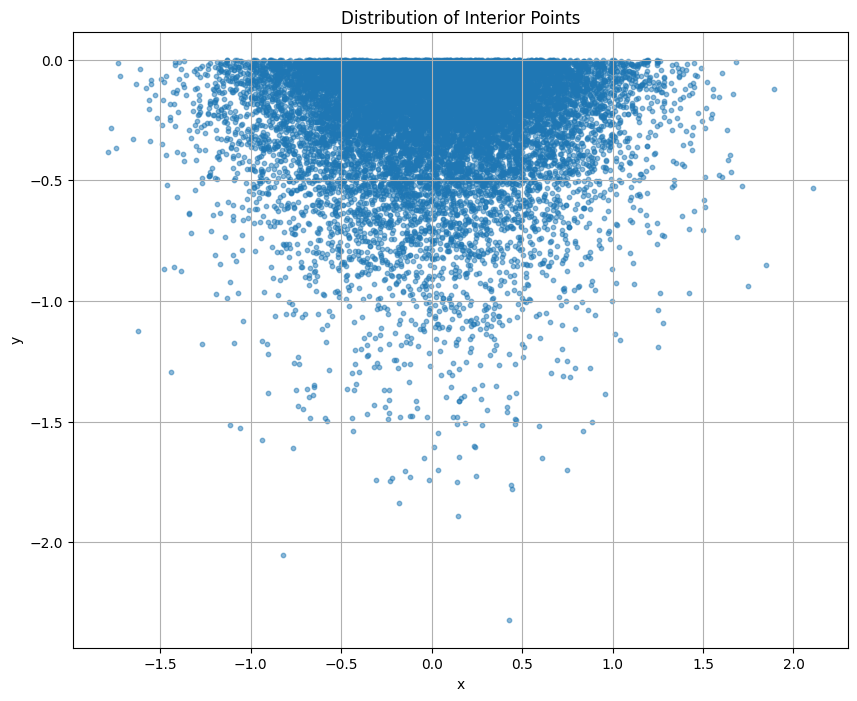

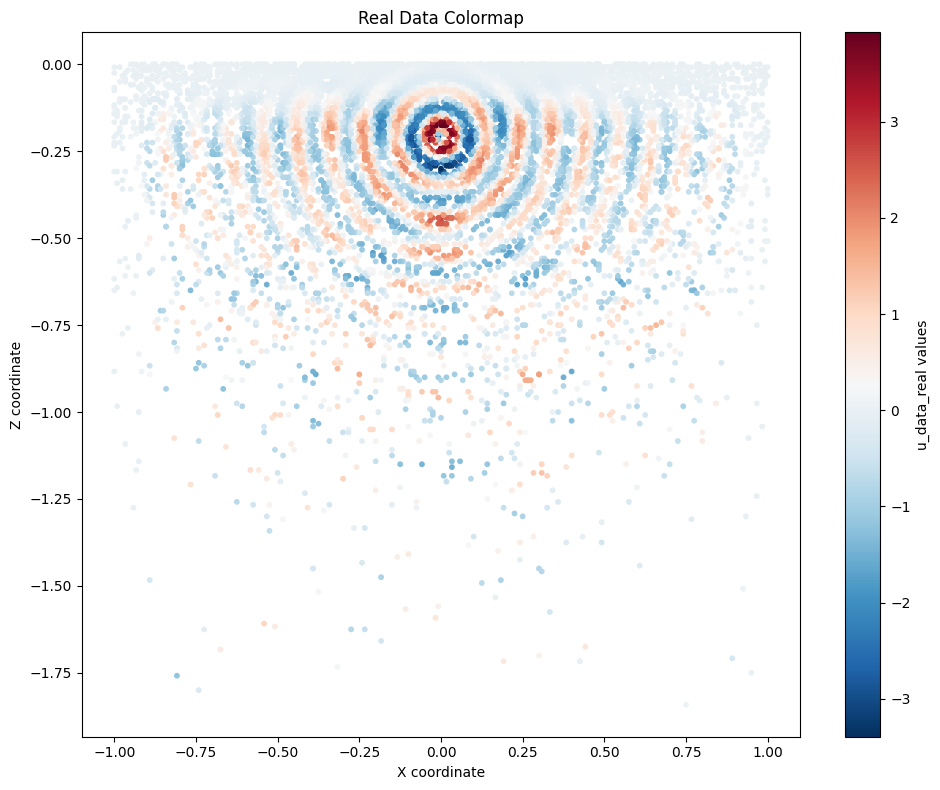

50177
>>> FASE 1: Entrenamiento con Adam <<<


Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

  [Adam epoch     1] total_loss=8.2127e+02, pde_loss_real=1.7130e+08, pde_loss_imag=1.7131e+08, data_loss_u_real=7.2298e-01, data_loss_u_imag=1.1923e+00, data_loss_k=6.2974e+00


Adam:   5%|▍         | 499/10000 [06:58<2:14:02,  1.18it/s]

  [Adam epoch   500] total_loss=1.9154e+02, pde_loss_real=1.4823e+03, pde_loss_imag=1.3585e-04, data_loss_u_real=7.1815e-01, data_loss_u_imag=1.1768e+00, data_loss_k=2.0451e-02


Adam:  10%|▉         | 999/10000 [14:06<2:06:28,  1.19it/s]

  [Adam epoch  1000] total_loss=1.9153e+02, pde_loss_real=1.4822e+03, pde_loss_imag=1.0862e-05, data_loss_u_real=7.1815e-01, data_loss_u_imag=1.1768e+00, data_loss_k=2.0302e-02


Adam:  15%|█▍        | 1499/10000 [21:15<2:03:14,  1.15it/s]

  [Adam epoch  1500] total_loss=1.9152e+02, pde_loss_real=1.4822e+03, pde_loss_imag=7.5540e-06, data_loss_u_real=7.1815e-01, data_loss_u_imag=1.1768e+00, data_loss_k=2.0232e-02


Adam:  20%|█▉        | 1999/10000 [28:28<1:55:20,  1.16it/s]

  [Adam epoch  2000] total_loss=1.9152e+02, pde_loss_real=1.4821e+03, pde_loss_imag=6.9972e-06, data_loss_u_real=7.1815e-01, data_loss_u_imag=1.1768e+00, data_loss_k=2.0203e-02


Adam:  25%|██▍       | 2499/10000 [35:40<1:47:27,  1.16it/s]

  [Adam epoch  2500] total_loss=1.9152e+02, pde_loss_real=1.4821e+03, pde_loss_imag=7.7186e-06, data_loss_u_real=7.1815e-01, data_loss_u_imag=1.1768e+00, data_loss_k=2.0192e-02


Adam:  30%|██▉       | 2999/10000 [42:56<1:48:55,  1.07it/s]

  [Adam epoch  3000] total_loss=1.9152e+02, pde_loss_real=1.4821e+03, pde_loss_imag=6.0722e-06, data_loss_u_real=7.1815e-01, data_loss_u_imag=1.1768e+00, data_loss_k=2.0188e-02


Adam:  34%|███▍      | 3387/10000 [48:34<1:34:50,  1.16it/s]


KeyboardInterrupt: 

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import torch
import torch.nn as nn
import matplotlib.colors as colors

from generate_data_points import generate_interior_data, sample_interior_data

# Configurar dispositivo CUDA
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

###############################################################################
# 1. Clases y funciones base
###############################################################################

class MLP_u(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, activation_function):
        super(MLP_u, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_units)
        self.linear_out = nn.Linear(hidden_units, output_size)
        self.layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers)])
        self.act = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x
    
class MLP_k(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, activation_function):
        super(MLP_k, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_units)
        self.linear_out = nn.Linear(hidden_units, output_size)
        self.layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers)])
        self.act = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x

def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    for _ in range(order):
        dy = torch.autograd.grad(
            dy, x,
            grad_outputs=torch.ones_like(dy),
            create_graph=True,
            retain_graph=True
        )[0]
    return dy

def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.0)

###############################################################################
# 2. Generar datos (observados y de colocalizaciÃ³n)
###############################################################################

def generate_interior_data_points(device):

    X_data_img_aux, u_data_img_aux = generate_interior_data('data/imag_part_0.0250Hz.csv','u')  # for raw data
    X_data_img, u_data_img = sample_interior_data(X_data_img_aux, u_data_img_aux, num_samples=10000, device='cpu')

    X_data_real_aux, u_data_real_aux = generate_interior_data('data/real_part_0.0250Hz.csv','u')  # for raw data
    X_data_real, u_data_real = sample_interior_data(X_data_real_aux, u_data_real_aux, num_samples=10000, device='cpu')

    X_data_c_aux, u_data_c_aux = generate_interior_data('data/velocity_model.csv','c')  # for raw data
    X_data_c, u_data_c = sample_interior_data(X_data_c_aux, u_data_c_aux, num_samples=10000, device='cpu')


    X_data_real = X_data_real.to(torch.float32)
    u_data_real = u_data_real.to(torch.float32)
    X_data_img = X_data_img.to(torch.float32)
    u_data_img = u_data_img.to(torch.float32)
    X_data_c = X_data_c.to(torch.float32)
    u_data_c = u_data_c.to(torch.float32)


    import matplotlib.pyplot as plt
    import numpy as np
    
    # Assuming X_data_real contains x,z coordinates and u_data_real contains the values
    # Convert tensors to numpy arrays if they're PyTorch tensors
    X = X_data_real.cpu().detach().numpy()
    u = u_data_real.cpu().detach().numpy()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create scatter plot with colormap
    scatter = ax.scatter(X[:, 0], X[:, 1], c=u, cmap='RdBu_r', s=10)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='u_data_real values')
    
    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Z coordinate')
    ax.set_title('Real Data Colormap')
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    

    return X_data_img, u_data_img, X_data_real, u_data_real, X_data_c, u_data_c


def generate_collocation_points(N_interior=2000, N_boundary=200):
    """
    Genera puntos de entrenamiento: interior (para el residual de la PDE)
    y frontera (para la condiciÃ³n de frontera u=0), en el dominio [-3,3]^2.

    Args:
        N_interior (int): NÃºmero de puntos interiores.
        N_boundary (int): NÃºmero de puntos en la frontera (y=0).

    Returns:
        (X_int, X_bnd) en formato (torch.Tensor, torch.Tensor).
    """
    # Puntos interiores en [-3,3]x[-3,3]
    x_int = np.random.normal(loc=0.0, scale=0.5, size=(N_interior, 1))
    y_int = - np.random.exponential(scale=0.25, size=(N_interior, 1))
    plt.figure(figsize=(10, 8))
    plt.scatter(x_int, y_int, alpha=0.5, s=10)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Distribution of Interior Points')
    plt.grid(True)
    plt.show()

    #y_int = np.clip(y_int, -100000, -0.01)  # fuerza a estar bajo el eje x

    X_int = np.hstack((x_int, y_int))  # (N_interior,2)
    X_int = torch.tensor(X_int, dtype=torch.float32, requires_grad=True)

    # Puntos sobre la lÃ­nea y = 0 (condiciÃ³n de frontera)
    x_bnd = np.random.normal(loc=0.0, scale=2.5, size=(N_boundary, 1))
    y_bnd = np.full((N_boundary, 1), 0.0)

    X_bnd = np.hstack((x_bnd, y_bnd))
    X_bnd = torch.tensor(X_bnd, dtype=torch.float32, requires_grad=True)
    
    return X_int, X_bnd
###############################################################################
# 3. DefiniciÃ³n de las pÃ©rdidas para el problema inverso
###############################################################################

def loss_pde_inverse_real(model_u, model_k, X_int, w):
    u = model_u(X_int)
    c = model_k(X_int)

    grads_u = derivative(u, X_int, order=1)
    u_x = grads_u[:, 0:1]
    u_y = grads_u[:, 1:2]

    u_xx = derivative(u_x, X_int, order=1)[:, 0:1]
    u_yy = derivative(u_y, X_int, order=1)[:, 1:2]

    x = X_int[:, 0:1]
    y = X_int[:, 1:2]
    
    sin = torch.sin
    exp = torch.exp
    cos = torch.cos
    pi = torch.pi
    sqrt = torch.sqrt
    f0 = 0.010
    t0 = 0
    forcing = 2*w**2*exp(torch.tensor(-w**2/f0**2))*cos(torch.tensor(2*pi*t0*w))/(sqrt(torch.tensor(pi))*f0**3)

    residual = (u_xx+u_yy) + (w/c)**2 - forcing
    
    return torch.mean(residual**2)

def loss_pde_inverse_imag(model_u, model_k, X_int, w):
    u = model_u(X_int)
    c = model_k(X_int)

    grads_u = derivative(u, X_int, order=1)
    u_x = grads_u[:, 0:1]
    u_y = grads_u[:, 1:2]

    u_xx = derivative(u_x, X_int, order=1)[:, 0:1]
    u_yy = derivative(u_y, X_int, order=1)[:, 1:2]

    x = X_int[:, 0:1]
    y = X_int[:, 1:2]
    
    sin = torch.sin
    exp = torch.exp
    cos = torch.cos
    pi = torch.pi
    sqrt = torch.sqrt
    f0 = 0.010
    t0 = 0
    forcing = -2 * w**2 * exp(torch.tensor(-w**2 / f0**2)) * sin(torch.tensor(2 * pi * t0 * w)) / (sqrt(torch.tensor(pi)) * f0**3)

    residual = (u_xx+u_yy) + (w/c)**2 - forcing
    
    return torch.mean(residual**2)

"""
def loss_bc(model, X_bnd, alpha=0.5, beta=10):
    x = X_bnd[:, 0:1]  # Solo la coordenada x, ya que y = 0
    u_true = torch.exp(-alpha * x**2)
    u_pred = model(X_bnd)

    return torch.mean((u_pred - u_true) ** 2)
"""
def loss_data_u_real(model, X_data, u_data):
    u_pred = model(X_data)
    return torch.mean((u_pred - u_data)**2)

def loss_data_u_imag(model, X_data, u_data):
    u_pred = model(X_data)
    return torch.mean((u_pred - u_data)**2)

def loss_data_k(model, X_data, k_data):
    k_pred = model(X_data)
    return torch.mean((k_pred - k_data)**2)

###############################################################################
# 4. FunciÃ³n para graficar la soluciÃ³n y k
###############################################################################

def plot_solution_and_k(modelU_real, modelU_imag, modelK, epoch, folder="figs_inverse_mixed", n_points=150):
    if not os.path.exists(folder):
        os.makedirs(folder)

    x_vals = np.linspace(-1, 1, n_points)
    y_vals = np.linspace(-2, 0, n_points)
    X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)
    XY_np = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T
    XY_torch = torch.tensor(XY_np, dtype=torch.float32, device=device)

    with torch.no_grad():
        u_pred_real = modelU_real(XY_torch).cpu().numpy()
        u_pred_imag = modelU_imag(XY_torch).cpu().numpy()

        k_pred = modelK(XY_torch).cpu().numpy()
    u_pred_real = u_pred_real.reshape(n_points, n_points)
    u_pred_imag = u_pred_imag.reshape(n_points, n_points)

    k_pred = k_pred.reshape(n_points, n_points)



    # Create a 2D figure with 4 subplots
    fig = plt.figure(figsize=(12, 10))
    """
    vmin = u_pred.min()
    vmax = u_pred.max()
    norm1 = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

    vmin = u_true.min()
    vmax = u_true.max()
    norm2 = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    """
    # 2D plot for PINN u
    ax1 = fig.add_subplot(3, 1, 1)
    im1 = ax1.pcolormesh(X_mesh, Y_mesh, u_pred_real, cmap='seismic', shading='auto')
    ax1.set_title(f"PINN u (epoch {epoch})")
    fig.colorbar(im1, ax=ax1)
    
    # 2D plot for Analytic u
    ax2 = fig.add_subplot(3, 1, 2)
    im2 = ax2.pcolormesh(X_mesh, Y_mesh, u_pred_imag, cmap='seismic', shading='auto')
    ax2.set_title("Analytic u")
    fig.colorbar(im2, ax=ax2)
    
    # 2D plot for Analytic k
    ax3 = fig.add_subplot(3, 1, 3)
    im3 = ax3.pcolormesh(X_mesh, Y_mesh, k_pred, cmap='GnBu', shading='auto')
    ax3.set_title("Analytic k")
    fig.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(folder, f"solution_epoch_{epoch}.png"))
    plt.close(fig)

###############################################################################
# 5. Entrenamiento
###############################################################################

def train_inverse_pinn_mixed(
    modelU_real, modelU_imag, modelK, w,
    X_int,
    X_data_img, u_data_img, X_data_real, u_data_real, X_data_c, u_data_c,
    adam_epochs=10000,
    lbfgs_iterations=500,
    lr_adam=1e-4,
    lr_lbfgs=0.5,
    lambda_bc=5.0, 
    lambda_data=1.0,
    plot_every=1000
):
    # Lists to store losses
    adam_loss_history = []
    lbfgs_loss_history = []

    optimizer_adam = torch.optim.Adam(list(modelU_real.parameters()) + list(modelU_imag.parameters()) + list(modelK.parameters()), lr=lr_adam)
    print(">>> FASE 1: Entrenamiento con Adam <<<")
    for epoch in tqdm(range(1, adam_epochs+1), desc="Adam"):
        optimizer_adam.zero_grad()

        pde_loss_real = loss_pde_inverse_real(modelU_real, modelK, X_int,w)
        pde_loss_imag = loss_pde_inverse_imag(modelU_imag, modelK, X_int,w)

        data_loss_val_u_real = loss_data_u_real(modelU_real, X_data_real, u_data_real)
        data_loss_val_u_imag = loss_data_u_imag(modelU_imag, X_data_img, u_data_img)

        data_loss_val_k = loss_data_k(modelK, X_data_c, u_data_c)
        #bc_loss = loss_bc(modelU, X_data)

        # In your Adam training loop
        total_loss = (
                    #pde_loss_real + pde_loss_imag + 
                    lambda_data * data_loss_val_u_real + 
                    lambda_data * data_loss_val_k + 
                    lambda_data * data_loss_val_u_imag)

        # Store the loss values before backward if you need them for printing
        loss_values = {
            'total_loss': total_loss.item(),
            'pde_loss_real': pde_loss_real.item(),
            'pde_loss_imag': pde_loss_imag.item(),
            'data_loss_u_real': data_loss_val_u_real.item(),
            'data_loss_u_imag': data_loss_val_u_imag.item(),
            'data_loss_k': data_loss_val_k.item()
        }
        
        total_loss.backward(retain_graph=True)
        optimizer_adam.step()

        # Now use loss_values for printing
        if epoch % plot_every == 0 or epoch == 1 or epoch == adam_epochs:
            adam_loss_history.append(loss_values['total_loss'])
            print(f"  [Adam epoch {epoch:5d}] total_loss={loss_values['total_loss']:.4e}, "
                f"pde_loss_real={loss_values['pde_loss_real']:.4e}, "
                f"pde_loss_imag={loss_values['pde_loss_imag']:.4e}, "
                f"data_loss_u_real={loss_values['data_loss_u_real']:.4e}, "
                f"data_loss_u_imag={loss_values['data_loss_u_imag']:.4e}, "
                f"data_loss_k={loss_values['data_loss_k']:.4e}")


            plot_solution_and_k(modelU_real,modelU_imag, modelK, epoch, folder=f"exp1/figs_inverse_w={w}")
    """
    print(">>> FASE 2: Entrenamiento con L-BFGS <<<")
    optimizer_lbfgs = torch.optim.LBFGS(
        list(modelU_real.parameters()) + list(modelU_imag.parameters()) + list(modelK.parameters()),
        lr=lr_lbfgs,
        max_iter=lbfgs_iterations,
        history_size=100
    )

    iteration_lbfgs = [0]
    def closure():
        optimizer_lbfgs.zero_grad()

        pde_loss_real = loss_pde_inverse_real(modelU_real, modelK, X_int,w)
        pde_loss_imag = loss_pde_inverse_imag(modelU_imag, modelK, X_int,w)

        data_loss_val_u_real = loss_data_u_real(modelU_real, X_data_real, u_data_real)
        data_loss_val_u_imag = loss_data_u_imag(modelU_imag, X_data_img, u_data_img)

        data_loss_val_k = loss_data_k(modelK, X_data_c, u_data_c)
        #bc_loss = loss_bc(modelU, X_data)

        total_loss = pde_loss_real + pde_loss_imag + lambda_data * data_loss_val_u_real + lambda_data * data_loss_val_k + lambda_bc * data_loss_val_u_imag

        total_loss.backward()
        return total_loss

    for i in tqdm(range(1, lbfgs_iterations+1)):
        iteration_lbfgs[0] += 1

        pde_loss_real = loss_pde_inverse_real(modelU_real, modelK, X_int,w).item
        pde_loss_imag = loss_pde_inverse_imag(modelU_imag, modelK, X_int,w).item

        data_loss_val_u_real = loss_data_u_real(modelU_real, X_data_real, u_data_real).item
        data_loss_val_u_imag = loss_data_u_imag(modelU_imag, X_data_img, u_data_img).item

        data_loss_val_k = loss_data_k(modelK, X_data_c, u_data_c).item
        #bc_loss = loss_bc(modelU, X_data)

        total_loss = pde_loss_real + pde_loss_imag + lambda_data * data_loss_val_u_real + lambda_data * data_loss_val_k + lambda_bc * data_loss_val_u_imag


        if (i+1) % 50 == 0 or (i+1) == lbfgs_iterations:
            lbfgs_loss_history.append(total_loss)
            print(f"  [Adam epoch {epoch:5d}] total_loss={total_loss.item():.4e}, "
                f"pde_loss_real={pde_loss_real.item():.4e}, "
                f"pde_loss_imag={pde_loss_imag.item():.4e}, "
                f"data_loss_u_real={data_loss_val_u_real.item():.4e}, "
                f"data_loss_u_imag={data_loss_val_u_imag.item():.4e}, "
                f"data_loss_k={data_loss_val_k.item():.4e}")
            
            plot_solution_and_k(modelU_real, modelU_imag, modelK, adam_epochs + i + 1, folder=f"exp1/figs_inverse_w={w}")
    """
    return modelU_real, modelU_imag, modelK, adam_loss_history, lbfgs_loss_history


###############################################################################
# 6. EjecuciÃ³n principal
###############################################################################

if __name__ == "__main__":
    set_seed(32)

    X_int, X_bnd = generate_collocation_points(N_interior=15000, N_boundary=5000)
    X_data_img, u_data_img, X_data_real, u_data_real, X_data_c, u_data_c = generate_interior_data_points(device='cpu')

    model_u_real = MLP_u(
        input_size=2,
        output_size=1,
        hidden_layers= 12,
        hidden_units=64,
        activation_function=nn.Tanh()
    ).to(device)
    model_u_real.apply(init_weights)

    model_u_imag = MLP_u(
        input_size=2,
        output_size=1,
        hidden_layers= 12,
        hidden_units=64,
        activation_function=nn.Tanh()
    ).to(device)
    model_u_imag.apply(init_weights)

    model_k = MLP_k(
        input_size=2,
        output_size=1,
        hidden_layers= 12,
        hidden_units=64,
        activation_function=nn.Tanh()
    ).to(device)
    model_k.apply(init_weights)

    # 2) Copia la parte común (entrada + capas ocultas)
    """
    model_k.linear_in.load_state_dict(model_k2d.in_layer.state_dict())
    for layer_uvk, layer_k2d in zip(model_k.layers, model_k2d.hidden):
        layer_uvk.load_state_dict(layer_k2d.state_dict())
    
    # 3) “Warm-start” del canal k en linear_out
    with torch.no_grad():
        # Copiando la fila 1 de los pesos (que sí es [H])
        model_k.linear_out.weight.data[0] = model_k2d.out.weight.data[0]
        # Copiando el bias escalar:
        model_k.linear_out.bias.data[0] = model_k2d.out.bias.data[0]

    plot_solution_and_k(model_u_real, model_u_imag, model_k, 0, folder="figs_inverse")
    """
    print(sum(p.numel() for p in model_u_real.parameters() if p.requires_grad) )

    w = 0.012
    model_u_real,model_u_imag, model_k, adam_LOSS, LGFGS_LOSS = train_inverse_pinn_mixed(
            model_u_real,model_u_imag, model_k, w,
            X_int,
            X_data_img, u_data_img, X_data_real, u_data_real, X_data_c, u_data_c,
            adam_epochs=10000,
            lbfgs_iterations=500,
            lr_adam=1e-4,
            lr_lbfgs=0.5,
            lambda_bc=5.0, 
            lambda_data=100.0,
            plot_every=500)

    plot_solution_and_k(model_u_real, model_u_imag, model_k, 0, folder="figs_inverse_mixed_final")

In [ ]:
def relative_error_analytic(model_u, model_k, n_points=200, device='cpu'):
    """
    Computes the relative percentage error between model predictions and ground truth for u and k.
    
    Args:
        model_u (torch.nn.Module): Trained model predicting u(x, y).
        model_k (torch.nn.Module): Trained model predicting k(x, y).
        alpha (float): Parameter in the analytic solution of u.
        beta (float): Parameter in the analytic solution of u.
        epsilon (float): Parameter in the analytic solution of k.
        n_points (int): Number of grid points in each dimension.
        device (str): 'cpu' or 'cuda'.

    Returns:
        Tuple of relative percentage errors for u and k: (rel_error_u, rel_error_k)
    """
    alpha = 0.5
    beta = 10
    epsilon = 0.2
    # Crear la malla
    x = np.linspace(-3, 3, n_points)
    y = np.linspace(-3, 0, n_points)
    X, Y = np.meshgrid(x, y, indexing='ij')
    XY_np = np.stack([X.flatten(), Y.flatten()], axis=1)

    # Convertir a tensor para usar en los modelos
    XY_tensor = torch.tensor(XY_np, dtype=torch.float32, device=device)

    with torch.no_grad():
        u_pred = model_u(XY_tensor).cpu().numpy().reshape(n_points, n_points)
        k_pred = model_k(XY_tensor).cpu().numpy().reshape(n_points, n_points)

    # Soluciones analíticas
    u_true = np.exp(-alpha * (X**2 + Y**2)) * np.cos(beta * Y)
    k_true = 1 + 2 / (1 + np.exp(-(Y+1) / epsilon))

    # Evitar división por cero
    u_true_safe = np.where(np.abs(u_true) < 1e-8, 1e-8, u_true)
    k_true_safe = np.where(np.abs(k_true) < 1e-8, 1e-8, k_true)

    # Error relativo porcentual promedio
    rel_err_u = np.mean(np.abs((u_pred - u_true) / u_true_safe)) * 100
    rel_err_k = np.mean(np.abs((k_pred - k_true) / k_true_safe)) * 100

    return rel_err_u, rel_err_k



In [37]:
relative_error_analytic(model_u, model_k, n_points=200, device='cpu')

(75102.31989480945, 25.47353456360522)